
# Music Source Separation with Hybrid Demucs

**Author**: [Sean Kim](https://github.com/skim0514)_

This tutorial shows how to use the Hybrid Demucs model in order to
perform music separation


## 1. Overview

Performing music separation is composed of the following steps

1. Build the Hybrid Demucs pipeline.
2. Format the waveform into chunks of expected sizes and loop through
   chunks (with overlap) and feed into pipeline.
3. Collect output chunks and combine according to the way they have been
   overlapped.

The Hybrid Demucs [[Défossez, 2021](https://arxiv.org/abs/2111.03600)_]
model is a developed version of the
[Demucs](https://github.com/facebookresearch/demucs)_ model, a
waveform based model which separates music into its
respective sources, such as vocals, bass, and drums.
Hybrid Demucs effectively uses spectrogram to learn
through the frequency domain and also moves to time convolutions.




## 2. Preparation

First, we install the necessary dependencies. The first requirement is
``torchaudio`` and ``torch``




In [1]:
!pip3 install torch
!pip3 install mir_eval
!pip3 install torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 957.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100703 sha256=dc78a589081be9913abee7cc53c84277b9bdb221862102cf34f7757c7178e9b2
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

2.1.0+cu118
2.1.0+cu118


In addition to ``torchaudio``, ``mir_eval`` is required to perform
signal-to-distortion ratio (SDR) calculations. To install ``mir_eval``
please use ``pip3 install mir_eval``.




In [3]:
from IPython.display import Audio
from mir_eval import separation
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
from torchaudio.utils import download_asset

## 3. Construct the pipeline

Pre-trained model weights and related pipeline components are bundled as
:py:func:`torchaudio.pipelines.HDEMUCS_HIGH_MUSDB_PLUS`. This is a
:py:class:`torchaudio.models.HDemucs` model trained on
[MUSDB18-HQ](https://zenodo.org/record/3338373)_ and additional
internal extra training data.
This specific model is suited for higher sample rates, around 44.1 kHZ
and has a nfft value of 4096 with a depth of 6 in the model implementation.



In [4]:
bundle = HDEMUCS_HIGH_MUSDB_PLUS

model = bundle.get_model()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

sample_rate = bundle.sample_rate

print(f"Sample rate: {sample_rate}")

100%|██████████| 319M/319M [00:02<00:00, 113MB/s]


Sample rate: 44100


## 4. Configure the application function

Because ``HDemucs`` is a large and memory-consuming model it is
very difficult to have sufficient memory to apply the model to
an entire song at once. To work around this limitation,
obtain the separated sources of a full song by
chunking the song into smaller segments and run through the
model piece by piece, and then rearrange back together.

When doing this, it is important to ensure some
overlap between each of the chunks, to accommodate for artifacts at the
edges. Due to the nature of the model, sometimes the edges have
inaccurate or undesired sounds included.

We provide a sample implementation of chunking and arrangement below. This
implementation takes an overlap of 1 second on each side, and then does
a linear fade in and fade out on each side. Using the faded overlaps, I
add these segments together, to ensure a constant volume throughout.
This accommodates for the artifacts by using less of the edges of the
model outputs.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/HDemucs_Drawing.jpg">



In [5]:
from torchaudio.transforms import Fade


def separate_sources(
    model,
    mix,
    segment=10.0,
    overlap=0.1,
    device=None,
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """
    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    chunk_len = int(sample_rate * segment * (1 + overlap))
    start = 0
    end = chunk_len
    overlap_frames = overlap * sample_rate
    fade = Fade(fade_in_len=0, fade_out_len=int(overlap_frames), fade_shape="linear")

    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model.forward(chunk)
        out = fade(out)
        final[:, :, :, start:end] += out
        if start == 0:
            fade.fade_in_len = int(overlap_frames)
            start += int(chunk_len - overlap_frames)
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0
    return final


def plot_spectrogram(stft, title="Spectrogram"):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    _, axis = plt.subplots(1, 1)
    axis.imshow(spectrogram, cmap="viridis", vmin=-60, vmax=0, origin="lower", aspect="auto")
    axis.set_title(title)
    plt.tight_layout()

## 5. Run Model

Finally, we run the model and store the separate source files in a
directory

As a test song, we will be using A Classic Education by NightOwl from
MedleyDB (Creative Commons BY-NC-SA 4.0). This is also located in
[MUSDB18-HQ](https://zenodo.org/record/3338373)_ dataset within
the ``train`` sources.

In order to test with a different song, the variable names and urls
below can be changed alongside with the parameters to test the song
separator in different ways.




In [6]:
# We download the audio file from our storage. Feel free to download another file and use audio from a specific path
SAMPLE_SONG = download_asset("tutorial-assets/hdemucs_mix.wav")
waveform, sample_rate = torchaudio.load(SAMPLE_SONG)  # replace SAMPLE_SONG with desired path for different song
waveform = waveform.to(device)
mixture = waveform

# parameters
segment: int = 10
overlap = 0.1

print("Separating track")

ref = waveform.mean(0)
waveform = (waveform - ref.mean()) / ref.std()  # normalization

sources = separate_sources(
    model,
    waveform[None],
    device=device,
    segment=segment,
    overlap=overlap,
)[0]
sources = sources * ref.std() + ref.mean()

sources_list = model.sources
sources = list(sources)

audios = dict(zip(sources_list, sources))

100%|██████████| 28.8M/28.8M [00:00<00:00, 33.6MB/s]


Separating track


### 5.1 Separate Track

The default set of pretrained weights that has been loaded has 4 sources
that it is separated into: drums, bass, other, and vocals in that order.
They have been stored into the dict “audios” and therefore can be
accessed there. For the four sources, there is a separate cell for each,
that will create the audio, the spectrogram graph, and also calculate
the SDR score. SDR is the signal-to-distortion
ratio, essentially a representation to the “quality” of an audio track.




In [7]:
N_FFT = 4096
N_HOP = 4
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)

### 5.2 Audio Segmenting and Processing

Below is the processing steps and segmenting 5 seconds of the tracks in
order to feed into the spectrogram and to caclulate the respective SDR
scores.




In [8]:
def output_results(original_source: torch.Tensor, predicted_source: torch.Tensor, source: str):
    print(
        "SDR score is:",
        separation.bss_eval_sources(original_source.detach().numpy(), predicted_source.detach().numpy())[0].mean(),
    )
    plot_spectrogram(stft(predicted_source)[0], f"Spectrogram - {source}")
    return Audio(predicted_source, rate=sample_rate)


segment_start = 150
segment_end = 155

frame_start = segment_start * sample_rate
frame_end = segment_end * sample_rate

drums_original = download_asset("tutorial-assets/hdemucs_drums_segment.wav")
bass_original = download_asset("tutorial-assets/hdemucs_bass_segment.wav")
vocals_original = download_asset("tutorial-assets/hdemucs_vocals_segment.wav")
other_original = download_asset("tutorial-assets/hdemucs_other_segment.wav")

drums_spec = audios["drums"][:, frame_start:frame_end].cpu()
drums, sample_rate = torchaudio.load(drums_original)

bass_spec = audios["bass"][:, frame_start:frame_end].cpu()
bass, sample_rate = torchaudio.load(bass_original)

vocals_spec = audios["vocals"][:, frame_start:frame_end].cpu()
vocals, sample_rate = torchaudio.load(vocals_original)

other_spec = audios["other"][:, frame_start:frame_end].cpu()
other, sample_rate = torchaudio.load(other_original)

mix_spec = mixture[:, frame_start:frame_end].cpu()

100%|██████████| 1.68M/1.68M [00:00<00:00, 14.6MB/s]
100%|██████████| 1.68M/1.68M [00:00<00:00, 27.8MB/s]
100%|██████████| 1.68M/1.68M [00:00<00:00, 34.9MB/s]
100%|██████████| 1.68M/1.68M [00:00<00:00, 15.6MB/s]


### 5.3 Spectrograms and Audio

In the next 5 cells, you can see the spectrograms with the respective
audios. The audios can be clearly visualized using the spectrogram.

The mixture clip comes from the original track, and the remaining
tracks are the model output




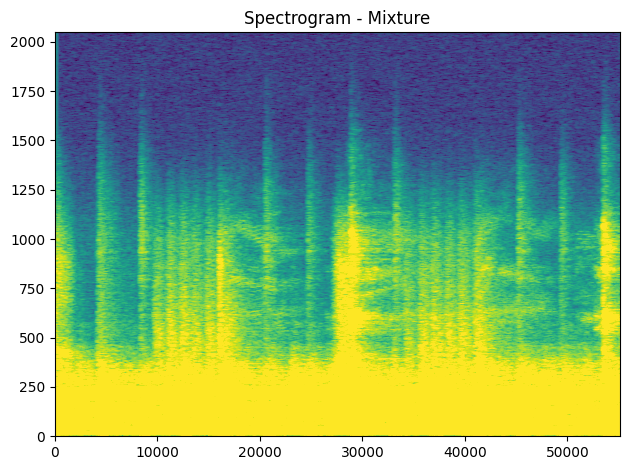

In [9]:
# Mixture Clip
plot_spectrogram(stft(mix_spec)[0], "Spectrogram - Mixture")
Audio(mix_spec, rate=sample_rate)

Drums SDR, Spectrogram, and Audio




SDR score is: 5.0177358679326565


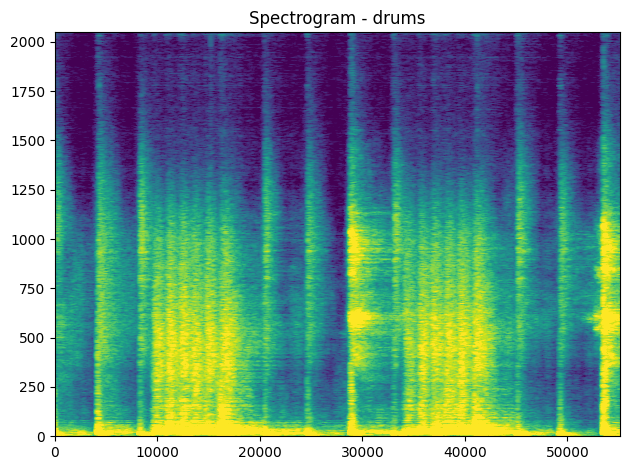

In [10]:
# Drums Clip
output_results(drums, drums_spec, "drums")

Bass SDR, Spectrogram, and Audio




SDR score is: 18.909251771345488


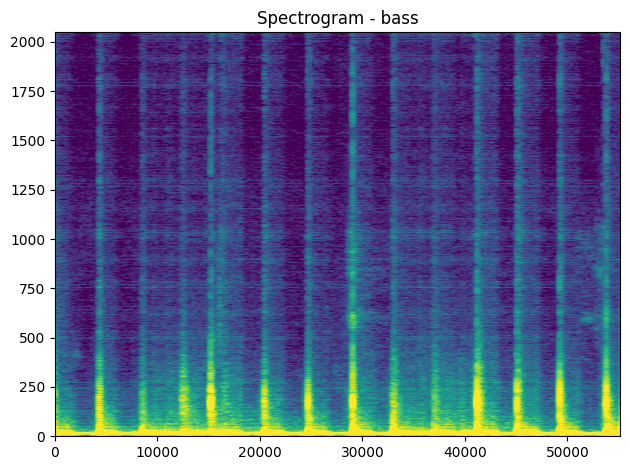

In [11]:
# Bass Clip
output_results(bass, bass_spec, "bass")

Vocals SDR, Spectrogram, and Audio




SDR score is: 8.792411498537138


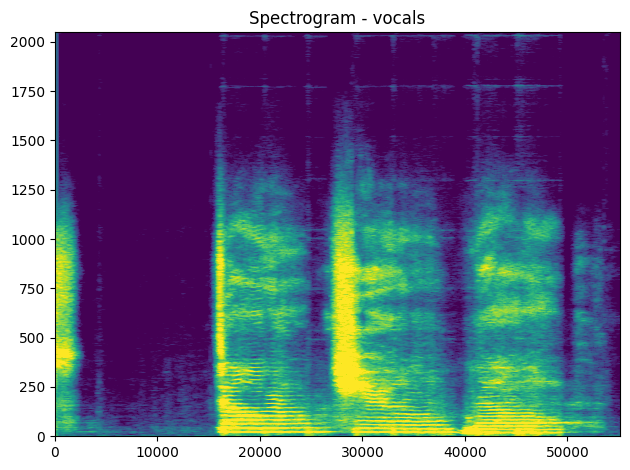

In [12]:
# Vocals Audio
output_results(vocals, vocals_spec, "vocals")

Other SDR, Spectrogram, and Audio




SDR score is: 8.86896686118104


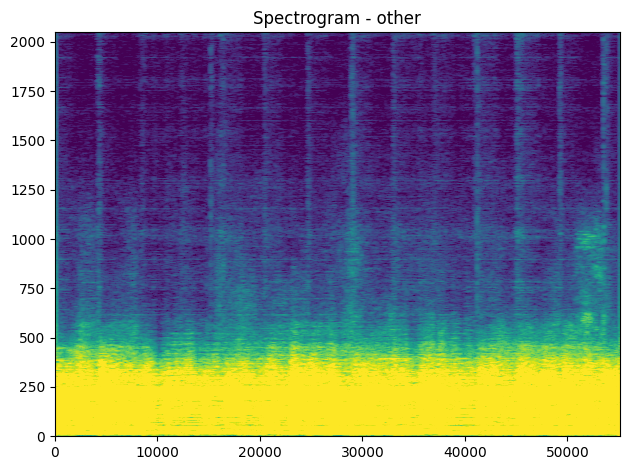

In [13]:
# Other Clip
output_results(other, other_spec, "other")

In [14]:
# Optionally, the full audios can be heard in from running the next 5
# cells. They will take a bit longer to load, so to run simply uncomment
# out the ``Audio`` cells for the respective track to produce the audio
# for the full song.
#

# Full Audio
# Audio(mixture, rate=sample_rate)

# Drums Audio
# Audio(audios["drums"], rate=sample_rate)

# Bass Audio
# Audio(audios["bass"], rate=sample_rate)

# Vocals Audio
# Audio(audios["vocals"], rate=sample_rate)

# Other Audio
# Audio(audios["other"], rate=sample_rate)

In [15]:
# Full Audio
Audio(mixture, rate=sample_rate)

In [16]:
# Drums Audio
Audio(audios["drums"], rate=sample_rate)

In [17]:
# Bass Audio
Audio(audios["bass"], rate=sample_rate)

In [18]:
# Vocals Audio
Audio(audios["vocals"], rate=sample_rate)

In [19]:
# Other Audio
Audio(audios["other"], rate=sample_rate)